In [148]:
import pandas
import numpy
import pylab
import math
import random
caminho_ngsim = r"C:\temp\ngsim\0750am-0805am\trajectories-0750am-0805am.csv"
caminho_ngsim = r"C:\temp\with_leading.csv"

Referimos a dados microscópicos quando estão presentes nos conjunto de dados informações específicas de cada veículo como posição, velocidade, aceleração e faixa.

Até relativamente recentemente, estes dados raramente eram disponíveis. Quando muito, poderia-se obter trajetória de um ou poucos veículos o que, claro, não deixa de ser interessante, mas parcos para o desenvolvimento de modelos de tráfego.

Felizmente, nos últimos 20 anos a disponibilidade deste tipo de dados aumentou consideravelmente devido ao desenvolvimento e barateamnento de tecnologias. Contribui para isso:

- processamento de imagens: há algoritmos poderosos para identificar veículos em imagens e para também seguí-los em uma sequência de imagens (vídeos). 
- tecnologias de comunicação (TC): dados cinemáticos (às vezes apenas posição aproximada) de grupos de veículos frequentemente disponíveis (frotas de taxi, frotas de ônibus, usuários de Google Maps ou Waze, etc.)
                            - caso clássico da oposição aos dados de laço indutivos. Dados de poucos veículos por toda rede de tráfego em vez de dados de todos os veículos em poucos pontos da rede tráfego.
- tecnonologia automotiva: veículos cada vez mais equipados com sensores e atuadores que guardam e disseminam (com auxilio das TC) informações do veículo específico

Estes dados passaram a ser muito úteis e permitem o estudo e análise de aspectos como:
- modelos de seguimento veícular: ainda que há uma literatura de como obter estes parâmetros de forma indireta, com trajetórias podemos observar diretamente aspectos como tempo de reação, comportamento de aceleração em diferentes contextos tais como diferencial de velocidade com relação ao veículo líder (i.e., se aproximando ou se afastando) entre outros
- modelos de trocas de faixa: quando ocorre a decisão de considerar a troca de faixas e quais são as condições necessárias para que este ato se concretiza?
- escolha de rotas: podemos observar e tentar explicar porque veículos que foram do ponto A ao ponto B em tempos semelhantes escolheram diferentes rotas. Aqui pode-se dizer que não é algo que envolve o comportamento de tráfego em si, mas a escolha de rotas é parte de pacotes de simulação de tráfego (seja macroscópico o microscópico) e interferem no resultado.

Neste módulo vamos processar dados do conjunto de dados NGSIM de 2006. Ainda que tenhamos novos conjunto de dados, este continua sendo relevante e os conceitos tratados aqui transferem-se também aos outros conjunto de dados.

- Tópico 1: calibrando um modelo de seguimento veícular sem processamento prévio
- Tópico 2: necessidade de pré-processamento e de restringir os dados a um contexto específico




Tópico 1: calibrando um modelo de seguimento veícular sem processamento prévio.

Neste item vamos:
   - carregar as trajetórias e seperar um sub-conjunto delas
   - separar 30 trajetórias para validação e calibrar o modelo IDM a partir de 10, 20 e 100 trajetórias
   - inferir a capacidade da via a partir destes dados.

In [175]:
df = pandas.read_csv(caminho_ngsim) #<-ngsim aqui é o csv atualizado para o csv com os dados

print(df)




         Unnamed: 0  Vehicle_ID  Frame_ID  Total_Frames    Global_Time  \
0                 0           2        13           437  1118846980200   
1                 1           2        14           437  1118846980300   
2                 2           2        15           437  1118846980400   
3                 3           2        16           437  1118846980500   
4                 4           2        17           437  1118846980600   
...             ...         ...       ...           ...            ...   
1048570     1048570        2783      8698           760  1118847848700   
1048571     1048571        2783      8699           760  1118847848800   
1048572     1048572        2783      8700           760  1118847848900   
1048573     1048573        2783      8701           760  1118847849000   
1048574     1048574        2783      8702           760  1118847849100   

         Local_X   Local_Y     Global_X     Global_Y  v_Length  ...  v_Vel  \
0         16.467    35.381  64511

Para começar a entender o conjunto de dados, uma sugestão é plotar 3-4 campos (velocidade, posicao, faixa, etc) de vários veículos para ver como as medidas variam ao longo do tempo.

In [ ]:
ids = list(df['Vehicle_ID'].unique())
#vamos pegar 10 veiculos aleatoriamente

ids_aleatorios = random.sample(ids, 6)
print(ids_aleatorios)

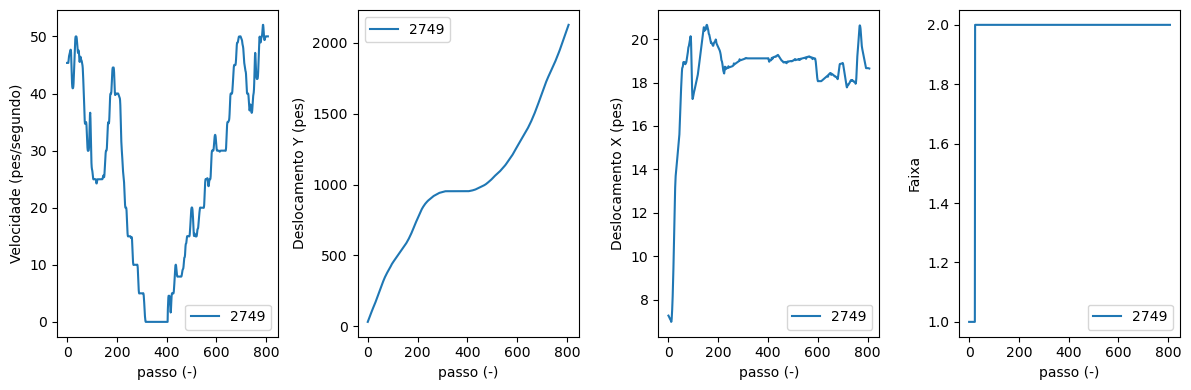

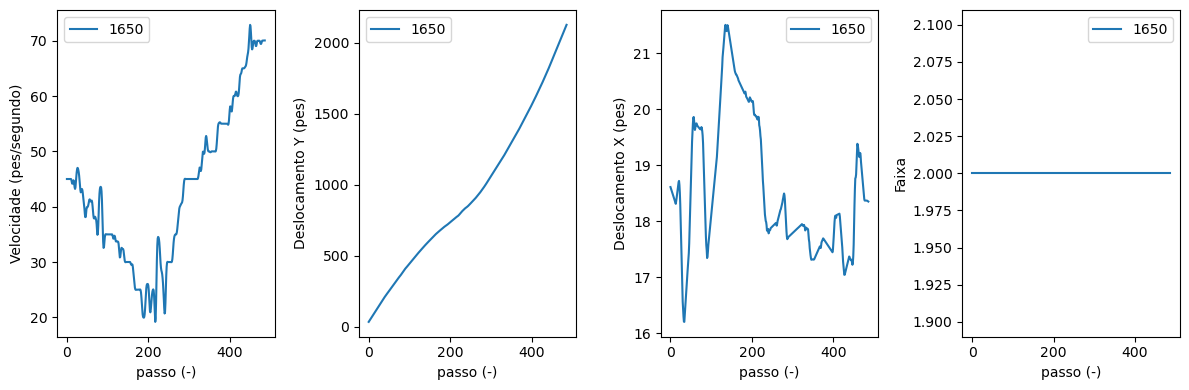

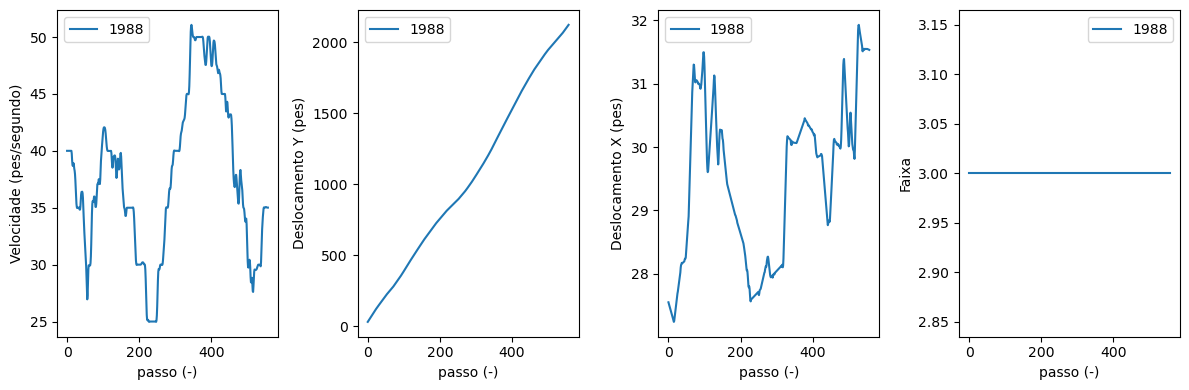

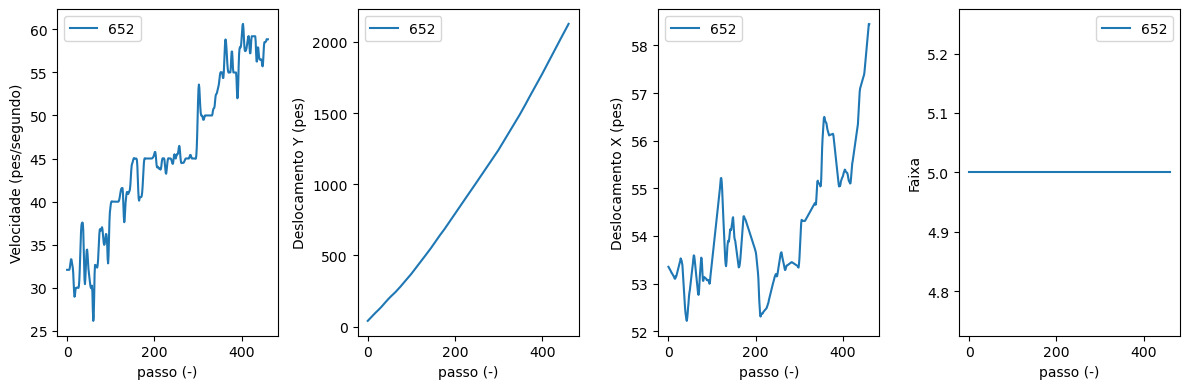

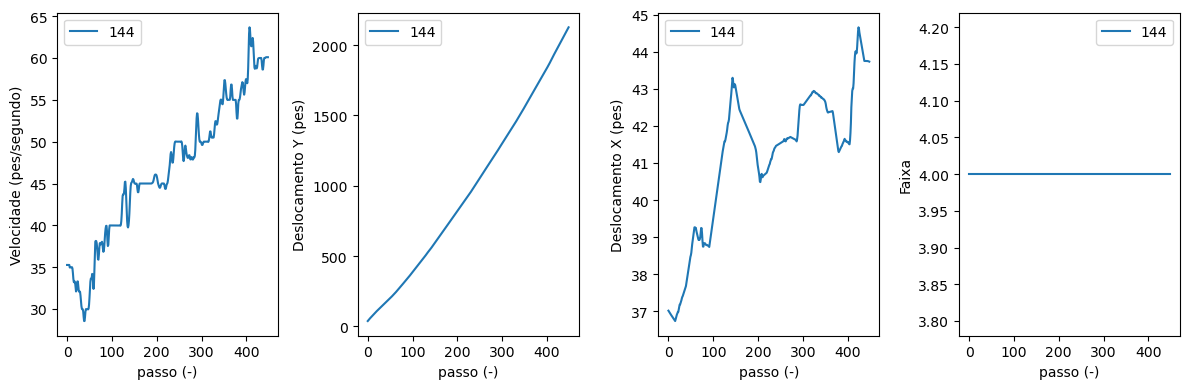

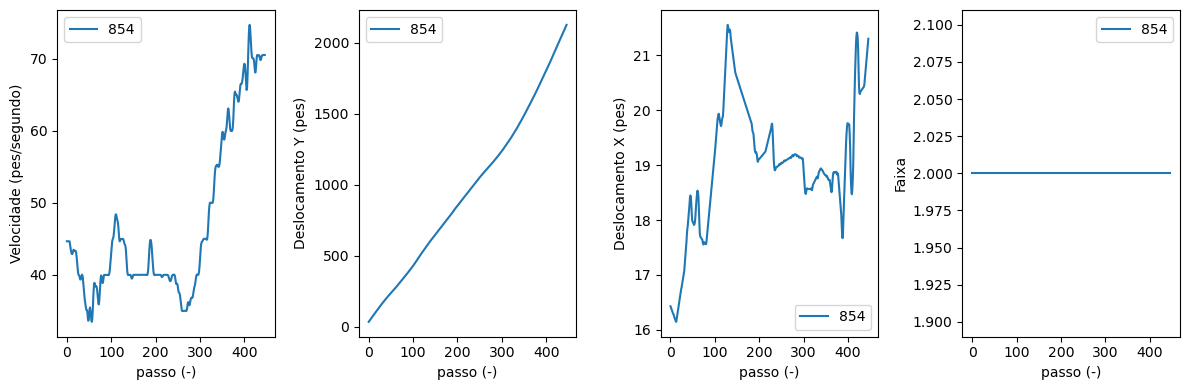

In [141]:



for id_aleatorio in ids_aleatorios:
    f, axs = pylab.subplots(1, 4, figsize=(12,4))
    veiculo = df[df['Vehicle_ID']==id_aleatorio]
   
    
    axs[0].plot(veiculo['v_Vel'].values, label=id_aleatorio)
    axs[1].plot(veiculo['Local_Y'].values, label=id_aleatorio)
    axs[2].plot(veiculo['Local_X'].values, label=id_aleatorio)
    axs[3].plot(veiculo['Lane_ID'].values, label=id_aleatorio)


    for i in range(4):
        axs[i].set_xlabel("passo (-)")
        axs[i].legend()
    axs[0].set_ylabel("Velocidade (pes/segundo)")
    axs[1].set_ylabel("Deslocamento Y (pes)")
    axs[2].set_ylabel("Deslocamento X (pes)")
    axs[3].set_ylabel("Faixa")
    pylab.tight_layout()
    pylab.show()

Observa que o deslocamento X é no sentido perpendicular ao fluxo e está relacionado a faixa em que o veículo se encontra. Quem se manteve entre 5-6m do mesmo valor de X não tem troca de faixa associada.

Veja a descontinuidade no valor X -> associado a erros na hora de associar a posição real (do centro do veículo) na imagem. No Y como os valores são maiores é mais difícil observar. Porém, olhando para a velocidade isto se torna claro.

O conjunto de dados rotula o veículo lider também e isto pode ocorrer de duas maneiras diferentes:
- troca de faixa de um veículo em outra faixa e tornando-se lider do veículo
- troca de faixa do veículo encontrando o líder em outra faixa.

Troca de faixas é uma das coisas distintas deste tipo de conjunto de dados. Vamos dar uma analisada em quantos diferentes líderes (Preceeding) cada veículo possui.

In [176]:
df_different_preceeding = df.groupby('Vehicle_ID')['Preceeding'].nunique().reset_index() #aqui estamos contando quantos líderes diferentes cada veículo possui. Lembrando que 0 é ninguem e é um valor válido.
print(df_different_preceeding['Preceeding'].value_counts())

Preceeding
2     888
3     631
4     292
5     107
6      47
7      13
1       5
8       5
9       2
11      1
16      1
26      1
Name: count, dtype: int64


Veja que o valor mínimo é 1 e trata-se de veículos que já estão na "borda" da área e ao final da área de estudo não é possível identificar o líder. Portanto a grande maioria tem 2 que seria o Zé-ninguem ao final da trajetória e algum veículo no meio do percurso

Na célula abaixo plotamos os 5 veículos cujo o número de líderes é apenas um

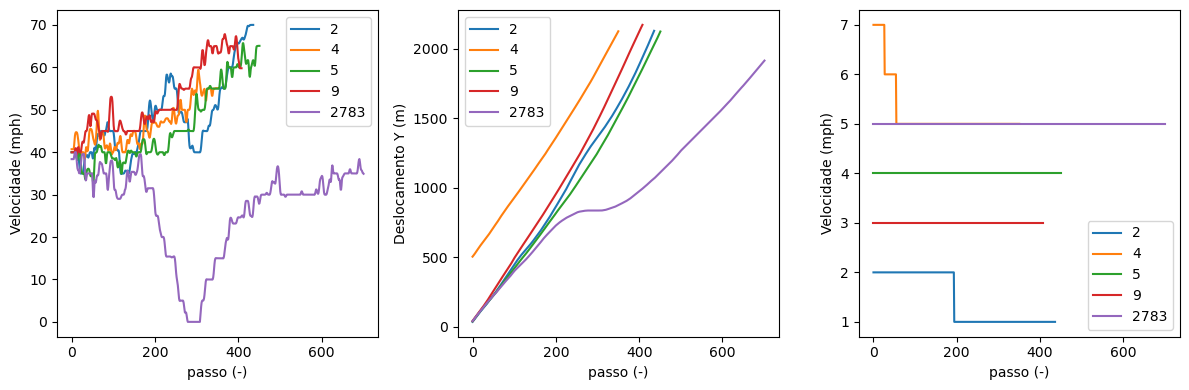

In [150]:
veiculos_com_um_lider = df_different_preceeding[df_different_preceeding['Preceeding']==1].reset_index()

f, axs = pylab.subplots(1, 3, figsize=(12,4))
for index, row in veiculos_com_um_lider.iterrows():
    veiculo = df[df['Vehicle_ID']==row['Vehicle_ID']]
   
    
    axs[0].plot(veiculo['v_Vel'].values, label=row['Vehicle_ID'])
    axs[1].plot(veiculo['Local_Y'].values, label=row['Vehicle_ID'])
    axs[2].plot(veiculo['Lane_ID'].values, label=row['Vehicle_ID'])


for i in range(3):
    axs[i].set_xlabel("passo (-)")
    axs[i].legend()
axs[0].set_ylabel("Velocidade (mph)")
axs[1].set_ylabel("Deslocamento Y (m)")
axs[2].set_ylabel("Faixa")
pylab.ylabel("Velocidade (mph)")
pylab.tight_layout()
pylab.show()

Faixa 1 é a da mais esquerda e Faixa 5 a mais a direita (6 e 7 são da rampa de entrada). O veículo 2783 provavelmente saiu pela rampa de saída. No momento de entrada esta faixa parece estar congestionada.

Agora vamos focar em um sub conjunto de trajetórias. Por simplicidade, vamos focar nas 107 trajetórias que tem 5 (4 veículos distintos e nenhum) diferentes líderes e vamos fazer um gráfico simuilar só para nos certificar que esses veículos cobrem diversas faixas, acelerações e etc.


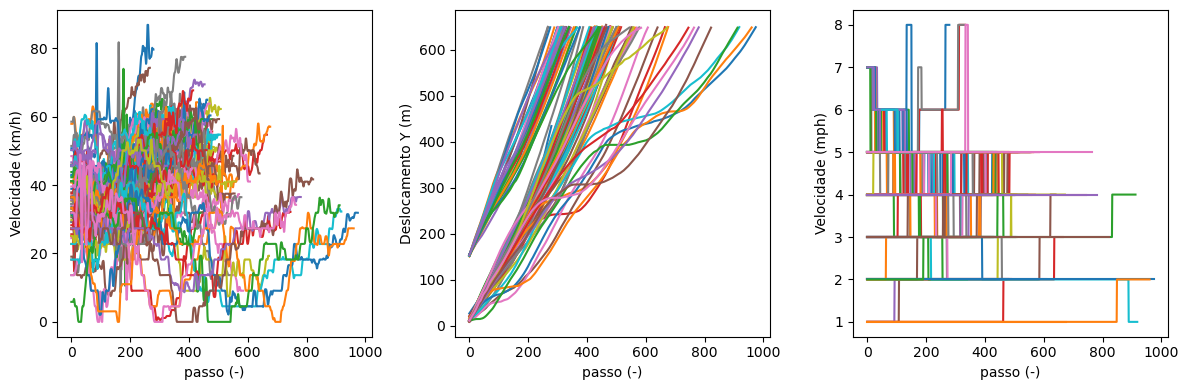

In [177]:
cinco_lideres = df_different_preceeding[df_different_preceeding['Preceeding']==5]

f, axs = pylab.subplots(1, 3, figsize=(12,4))
for index, row in cinco_lideres.iterrows():
    veiculo = df[df['Vehicle_ID']==row['Vehicle_ID']]
   
    
    axs[0].plot(veiculo['v_Vel'].values/1.097, label=row['Vehicle_ID']) #velocidade em pes/segundo convertido para kmm/h
    axs[1].plot(veiculo['Local_Y'].values*0.3049, label=row['Vehicle_ID']) #deslocamento em pes convertido para m
    axs[2].plot(veiculo['Lane_ID'].values, label=row['Vehicle_ID'])


for i in range(3):
    axs[i].set_xlabel("passo (-)")
axs[0].set_ylabel("Velocidade (km/h)")
axs[1].set_ylabel("Deslocamento Y (m)")
axs[2].set_ylabel("Faixa")
pylab.ylabel("Velocidade (mph)")
pylab.tight_layout()
pylab.show()

Todas as faixas e velocidades estão presentes, mas arbitrariamente vamos descartar as seguintes características:
- uso da faixa HOV ("carona") - sabidamente veículos trafegam bem mais rápido por esta faixa
- utilização das faixas 7 e 8

In [179]:
df_final = df[df['Vehicle_ID'].isin(cinco_lideres['Vehicle_ID'].values)]

df_max_lanes = df_final.groupby(by='Vehicle_ID').max()
df_lanes_78 = df_max_lanes[df_max_lanes['Lane_ID'].isin((7,8))].reset_index()
print("total de veiculos nas faixas 7 e 8", df_lanes_78['Vehicle_ID'].count())
df_min_lanes = df_final.groupby(by='Vehicle_ID').min()
df_lanes_1 = df_min_lanes[df_min_lanes['Lane_ID']==1].reset_index()
print("total de veiculos nas faixas 1", df_lanes_1['Vehicle_ID'].count())
print(df_lanes_78['Vehicle_ID'].unique())
print(df_lanes_1['Vehicle_ID'].unique())
to_remove = []
to_remove.extend(df_lanes_78['Vehicle_ID'].unique())
to_remove.extend(df_lanes_1['Vehicle_ID'].unique())

df_final = df_final[~df_final['Vehicle_ID'].isin(to_remove)].reset_index()
print("Ficaram esse total de veículos", df_final['Vehicle_ID'].unique().shape)
conjunto_cinco_lideres = set(df_final['Vehicle_ID'].unique())

total de veiculos nas faixas 7 e 8 33
total de veiculos nas faixas 1 6
[  35  352  358  402  407  452  679  695  710  724  732  741  752  758
  790  816 1126 1150 1333 1349 1371 1407 1428 1547 1966 2068 2072 2122
 2282 2353 2365 2406 2473]
[ 132  396  991 1616 2615 2621]
Ficaram esse total de veículos (68,)


Removemos alguns veículos do conjunto de dados (33 por estarem nas faixas mais a direita) e 6 por estar na faixa HOV.

Sobram 68 veículos. Vamos agora fazer um conjunto de dados só com esses veículos e adicionar a velocidade e aceleração do lider como novas colunas. Primeiro temos que identificar para cada registro qual é o registro correspondente do lider.

Esta operação demora um pouco. Possivelmente seria mais rápido definindo índices, mas deixamos assim por enquanto.

Não focamos por enquanto, mas o conjutno de dados original apresenta o veículo líder, mas não sua velocidade e posição naquele momento. No entanto, podemos obter isto "olhando" para o registro daquele veículo naquele mesmo instante e buscar sua velocidade e aceleração.

O código abaixo faz exatamente isso. Por se tratar de algo que durou um tempo maior (umas 2h), o conjunto de dados para o mini-curso já tem as informações no qual o código abaixo realiza.

É bem provável que com o correto uso de índices o código abaixo seja executado em segundos. Como não é o foco, deixamos simples por enquanto.

In [ ]:
#agora vamos adicionar duas novas colunas no nosso dataFrame baseado nos valores que já temos. Velocidade e aceleracao do veiculo lider
#para isso vamos criar um dicionario com o indice correspondente do lider

match_by_index = {}
count = 0
for index, row in df.iterrows():
    # if row['Vehicle_ID'] not in conjunto_vehicles:
    #     continue
    if row['Preceeding']>0:
        registro = df.loc[(df['Vehicle_ID']==row['Preceeding']) & (df['Global_Time']==row['Global_Time'])]
        #print(registro.count())
        for the_idx, row in registro.items():
            match_by_index[index] = registro.first_valid_index()
        
    else:
        match_by_index[index] = None

    count += 1
    if count%5000==0:
        print("registros processados ", count)
print(len(match_by_index))

def obter_velocidade_lider(indice):
    if indice not in match_by_index:
        return -1
    
    indice_lider = match_by_index[indice]

    if indice_lider is None:
        return -1

    return df.loc[indice_lider,'v_Vel']

def obter_acc_lider(indice):
    if indice not in match_by_index:
        return None
    indice_lider = match_by_index[indice]

    if indice_lider is None:
        return None

    return df.loc[indice_lider,'v_Acc']


df['index'] = df.index
df['Preceeding_Vel'] = df['index'].apply(obter_velocidade_lider)
df['Preceeding_v_Acc'] = df['index'].apply(obter_acc_lider)

df.to_csv("C:\\temp\\with_leading.csv")


registros processados  5000
registros processados  10000
registros processados  15000
registros processados  20000
registros processados  25000
registros processados  30000
registros processados  35000
registros processados  40000
registros processados  45000
registros processados  50000
registros processados  55000
registros processados  60000
registros processados  65000
registros processados  70000
registros processados  75000
registros processados  80000
registros processados  85000
registros processados  90000
registros processados  95000
registros processados  100000
registros processados  105000
registros processados  110000
registros processados  115000
registros processados  120000
registros processados  125000
registros processados  130000
registros processados  135000
registros processados  140000
registros processados  145000
registros processados  150000
registros processados  155000
registros processados  160000
registros processados  165000
registros processados  170000


O gráfico abaixo mostra o padrão de troca de líderes para um certo veículo

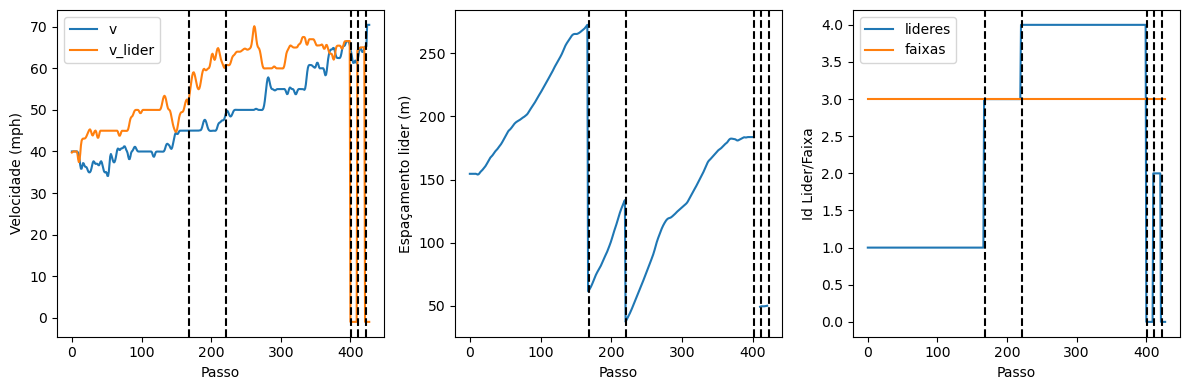

428 428


In [151]:
#vamos validar para ver se os resultados fazem sentido
df_47 = df[df['Vehicle_ID']==47].reset_index()
#df_47.to_csv("C:\\temp\\data.csv")
leading = list(df_47['Preceeding'].unique())
leading.sort()

leading_indices = []

leading_speeds = []
ego_speeds = []
spacings = []

vertical_lines = []
lanes = []
for idx, row in df_47.iterrows():
    leading_indices.append(leading.index(row['Preceeding']))
    lanes.append(row['Lane_ID'])
    leading_speeds.append(row['Preceeding_Vel'])

    if len(leading_indices) > 1 and leading_indices[-2] != leading_indices[-1]:
        vertical_lines.append(len(leading_indices))

    ego_speeds.append(row['v_Vel'])
    if leading_indices[-1] != 0:
        spacings.append(row['Space_Hdwy'])
    else:
        spacings.append(None)

f, axs = pylab.subplots(1,3, figsize=(12,4))
axs[0].plot(ego_speeds, label='v')
axs[0].plot(leading_speeds, label='v_lider')
axs[1].plot(spacings)
axs[2].plot(leading_indices, label='lideres')
axs[2].plot(lanes, label='faixas')

for transicao in vertical_lines:
    for j in range(3):
        axs[j].axvline(transicao, linestyle='--', color='black')

for j in range(3):
    axs[j].set_xlabel("Passo")

axs[0].set_ylabel("Velocidade (mph)")
axs[0].legend()
axs[1].set_ylabel("Espaçamento lider (m)")
axs[2].set_ylabel("Id Lider/Faixa")
axs[2].legend()
pylab.tight_layout()

pylab.show()
print(len(leading_indices), len(leading_speeds))


**Calibracao/MODELO IDM**

Agora chegou a hora de processar estes dados. Vamos implementar o IDM model e vamos comparar uma trajetória com alguns parâmetros razoáveis e testar se nossa função objetivo está fazendo sentido.

Não é o foco aqui discutir o detalhe. O código abaixo implementa o modelo IDM pela discretização de Euler retornando um vetor de velocidade e posições. 

Informações sobre este modelo está disponível em vários lugares, inclusive na Wikipedia (Figura abaixo)

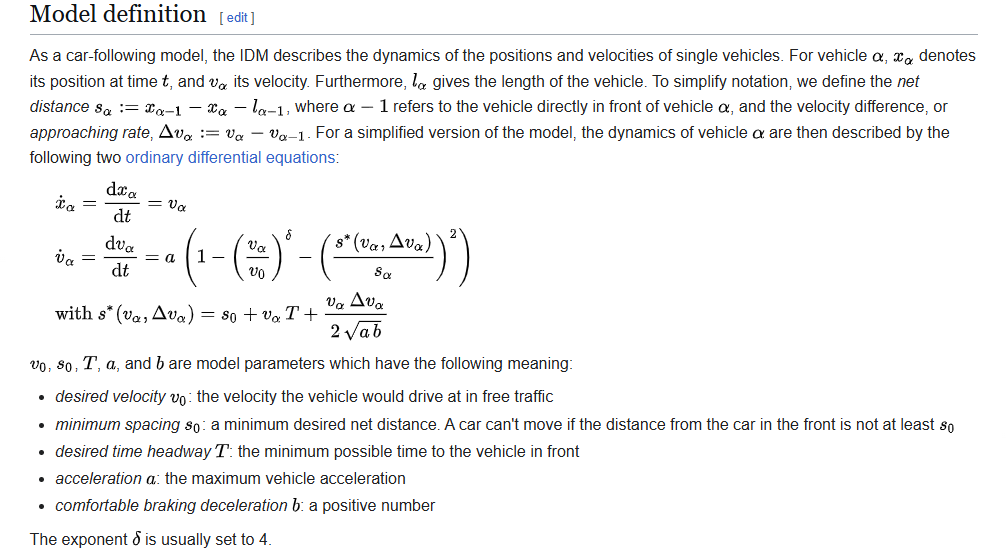

In [101]:
VEL = 1
POS = 0
def processa_idm(velocidade_inicial, vetor_lider, V, A, B, T, S_0, Delta, Passo):
    DOIS_RAIZ_AB = 2*math.sqrt(A*B)
    numero_passos = vetor_lider.shape[0]

    vetor_veiculo = numpy.zeros((vetor_lider.shape))
    vetor_veiculo[0, VEL] = velocidade_inicial

    for t in range(1,numero_passos):
        delta_v = vetor_veiculo[t-1,VEL]-vetor_lider[t-1, VEL]

        s_star = S_0+vetor_veiculo[t-1,VEL]*T+vetor_veiculo[t-1,VEL]*delta_v/DOIS_RAIZ_AB
        den = vetor_lider[t-1,POS]-vetor_veiculo[t-1, POS]

        

        if abs(den) < 0.1:
            den = 0.1

        try:
            acel = A*(1-math.pow(vetor_veiculo[t-1,VEL]/V, Delta)- math.pow((s_star/den),2))
        except:
            print(vetor_veiculo)
            raise


        #calculamos a aceleracao agora atualizamos posicao e velocidade
        #estamos utilizando aqui a discretizacao de euler que é a mais simples.
        vetor_veiculo[t,VEL] = max(0,vetor_veiculo[t-1,VEL]+acel*Passo)
        vetor_veiculo[t,POS] = vetor_veiculo[t-1,POS]+ vetor_veiculo[t-1,VEL]*Passo
        
    return vetor_veiculo

Vamos avaliar o modelo considerando um veículo líder que mantem velocidade constante de 25m/s. O veículo que segue inicia a trajetória com velocidade de 12m/s a uma distância de 40m do veículo líder.

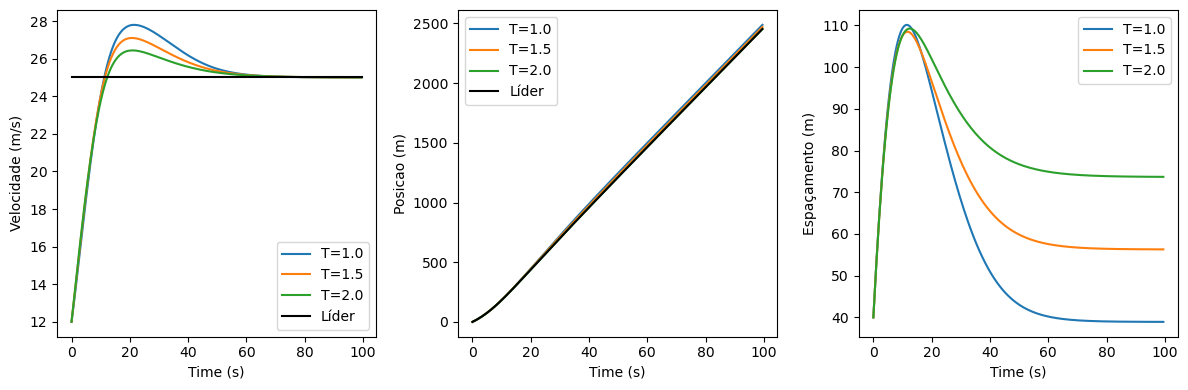

In [152]:
PASSOS = 200
PASSO = 0.5
vetor_lider = numpy.zeros((PASSOS,2))
vetor_lider[:,VEL] = 25.0
tempos = [t*PASSO for t in range(PASSOS)]
for t in range(PASSOS):
    vetor_lider[t,POS] = 40+25*t*PASSO

f, axs = pylab.subplots(1,3, figsize=(12,4))
for T in [1.0, 1.5, 2.0]:
    vetor_veiculo = processa_idm(12.0, vetor_lider, 30.0,1.5, 4.0, T, 3, 4, PASSO)
    axs[0].plot(tempos, vetor_veiculo[:, VEL], label=f'T={T}')
    axs[1].plot(tempos, vetor_veiculo[:, POS], label=f'T={T}')
    axs[2].plot(tempos, vetor_lider[:,POS]-vetor_veiculo[:, POS], label=f'T={T}')

axs[0].plot(tempos, vetor_lider[:,VEL], label='Líder', color='black')
axs[1].plot(tempos, vetor_veiculo[:,POS], label='Líder', color='black')
axs[0].legend()
axs[1].legend()
axs[2].legend()
for i in range(3):
    axs[i].set_xlabel("Time (s)")
axs[0].set_ylabel("Velocidade (m/s)")
axs[1].set_ylabel("Posicao (m)")
axs[2].set_ylabel("Espaçamento (m)")

pylab.tight_layout()
pylab.show()

Esse é o ocmportamento clássico de um modelo de seguimento veícular. Dado que o carro líder mantem uma velocidade fixa, o veículo que segue atinge essa velocidade em regime permanente porém qual o espaçamento e resposta dinâmica depende dos parâmetros.

No caso específico do modelo IDM:
- o espaçamento em regime permanente depende depende do S0 (espaçamento mínimo) e T (time gap)
- aceleração e desaceleração conjuntamente definem o padrão de aceleração e desaceleração
- o expoente "modifica" o padrão de espaçamento e velocidade em regime permanente

Agora a pergunta que fica se a partir dos dados conseguimos achar o melhor conjunto de parâmetros.

Para isso vamos criar dicionários específicos para cada veículo.

In [153]:
PE_PARA_METRO = 0.3049
PASSO_NGSIM = 0.1

def cria_entrada_por_veiculo(conjunto_veiculos):
    entradas_por_veiculo = {}

    for id_veiculo in conjunto_veiculos:
        df_veiculo = df[df['Vehicle_ID']==id_veiculo].reset_index()

        velocidades_observadas = 0.3049*df_veiculo['v_Vel'].to_numpy()
        posicoes_observadas = numpy.zeros(velocidades_observadas.shape)
        for t in range(1, velocidades_observadas.shape[0]):
            posicoes_observadas[t] = posicoes_observadas[t-1]+velocidades_observadas[t-1]*PASSO_NGSIM
        
        vetor_lider = numpy.zeros((velocidades_observadas.shape[0], 2))
        vetor_lider[:,VEL] = df_veiculo['Preceeding_Vel'].to_numpy()*0.3049
        vetor_lider[:, POS] = posicoes_observadas+df_veiculo['Space_Hdwy'].to_numpy()*0.3049

        entradas_por_veiculo[id_veiculo] = {'velocidades_observadas': velocidades_observadas,
                                            'posicoes_observadas': posicoes_observadas,
                                            'vetor_lider': vetor_lider}

    return entradas_por_veiculo




Vamos criar uma função que plota gráfico comparando os dados reais e os dados simulados que depois utilizaremos múltiplas vezes.

In [169]:
def plota_comparacao(entrada_veiculo, vetor_simulado, id_veiculo, axs = None, plot=True, label=True):
    adiciona_lider = True
    if axs is None:
        f, axs = pylab.subplots(1,3, figsize=(12,4))
        for i in range(3):
            axs[i].set_xlabel("Passo (-)")
        axs[0].set_ylabel("Velocidade (m/s)")
        axs[1].set_ylabel("Posicao")
        axs[2].set_ylabel("Erro de posicao (m)")
        adiciona_lider = False

    axs[0].plot(vetor_simulado[:, VEL], label=label)
    axs[0].plot(entrada_veiculo['velocidades_observadas'], color='black')
    axs[0].plot(entrada_veiculo['vetor_lider'][:,VEL], color='gray', linestyle='--')

    if adiciona_lider:
        axs[1].plot(entrada_veiculo['posicoes_observadas'], color = 'black', label='obs')
        axs[1].plot(entrada_veiculo['vetor_lider'][:,POS],color='gray', linestyle='--',
                    label='lider_obs')
    axs[1].plot(vetor_simulado[:,POS], label=label)

    axs[2].plot(entrada_veiculo['posicoes_observadas']-vetor_simulado[:,POS], label=label)

    if plot:
        axs[2].legend()
        pylab.tight_layout()
        pylab.show()
    return axs

Abaixo vamos focar em uma única trajetória só para ver que os dados fazem sentido e que a definição da função objetivo está correta.

0 40770.40007297778
1 27805.050746871017
2 69574.35330495385
3 40547.18260683968
4 33764.32664493755


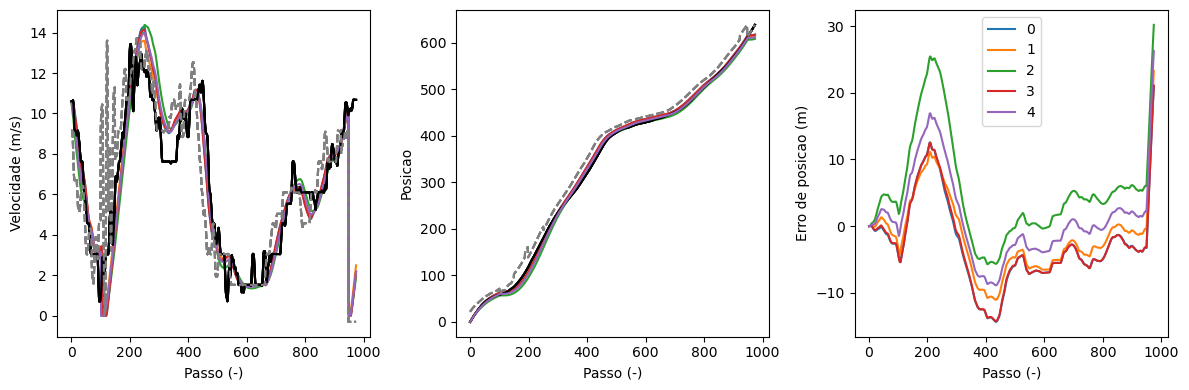

In [180]:
#vamos pegar uma unica trajetoria para estudar um pouco o resultado da simulacao

max_v = -1
key = None

entradas_por_veiculo = cria_entrada_por_veiculo(conjunto_cinco_lideres)
for id_veiculo in entradas_por_veiculo:
    sz = entradas_por_veiculo[id_veiculo]['velocidades_observadas'].shape[0]
    if sz > max_v:
        max_v = sz
        key = id_veiculo

entradas = [(30.0,1.5, 4.0, 1.5, 3),
            (30.0,1.5, 4.0, 1.8, 3),
            (30.0,1.5, 4.0, 1.6, 10),
            (25.0,1.5, 3.5, 1.5, 3),
            (30.0,1.5, 4.0, 1.7, 6)
            ]

def funcao_objectivo(posicoes_observadas, vetor_simulado):
    length = len(posicoes_observadas)
    int_from = int(0.1*length)
    int_to = int(0.8*length)
    soma_quadrados = numpy.sum(numpy.square(posicoes_observadas[int_from:int_to]-vetor_simulado[int_from:int_to,POS]))

    return soma_quadrados


axs = None
for u,(V, A, B, T, S_0) in enumerate(entradas):
    v0 = entradas_por_veiculo[key]['velocidades_observadas'][0]
    vetor_simulado = processa_idm(v0, entradas_por_veiculo[key]['vetor_lider'],
                                  V, A, B, T, S_0, 4, 0.1)
    
    axs = plota_comparacao(entradas_por_veiculo[key], vetor_simulado, key, axs=axs, label=u, plot=False)
    #axs[0].plot(vetor_simulado[:, VEL])
    #axs[1].plot(entradas_por_veiculo[key]['posicoes_observadas']-vetor_simulado[:,POS], label=u)
    print(u, funcao_objectivo(entradas_por_veiculo[key]['posicoes_observadas'], vetor_simulado))
    
axs[2].legend()
pylab.tight_layout()
pylab.show()


A nossa função objetivo parece fazer sentido e as trajetórias também. Vamos agora realizar a calibração para dois conjunto de veículos.

- o conjunto com 5 lideres
- um conjunto de mesmo número de trajetórias porém com veículos que usam a faixa mais a esquerda (HOV) e que portantao tem menos líderes.


In [184]:
conjunto_cinco = list(conjunto_cinco_lideres)
print("total de veiculos", len(conjunto_cinco))
n_calibracao = int(0.75*len(conjunto_cinco))
n_validacao = len(conjunto_cinco)-n_calibracao
indices_calibracao_cinco = random.sample(conjunto_cinco, n_calibracao)
indices_validacao_cinco = [el for el in conjunto_cinco if el not in indices_calibracao_cinco]
print(indices_calibracao_cinco)
print(indices_validacao_cinco)

total de veiculos 68
[2395, 1609, 1029, 1000, 595, 436, 1647, 1335, 603, 2139, 2408, 2618, 71, 1001, 99, 2267, 2098, 2726, 2586, 1512, 2129, 645, 2364, 1837, 597, 2126, 798, 1022, 1392, 837, 1505, 1767, 47, 1560, 513, 2501, 1643, 2680, 810, 135, 1574, 339, 2750, 1013, 1014, 1321, 2071, 2754, 2681, 1272, 943]
[394, 522, 1783, 792, 545, 1962, 51, 1336, 577, 198, 205, 462, 986, 483, 1649, 1269, 1276]


Esta aí o conjunto com 75% dos veículos usado para calibração e o restante para validação. Vamos fazer a mesma coisa para os aleatórios.

In [ ]:
grupo = df.groupby(by='Vehicle_ID').min()
df_hov = grupo[grupo["Lane_ID"]==1].reset_index()
veiculos_hov = df_hov["Vehicle_ID"].unique()
calibracao_esquerda = random.sample(list(veiculos_hov), n_calibracao)
validacao_esquerda = random.sample(list(veiculos_hov), n_validacao)
print(calibracao_esquerda)
print(validacao_esquerda)



[475, 2304, 1521, 588, 450, 2633, 1978, 675, 2140, 1549, 1016, 1039, 529, 2615, 571, 1945, 200, 2487, 1694, 1325, 1462, 1599, 1913, 1337, 966, 2674, 605, 1267, 2209, 1881, 749, 2337, 1147, 271, 762, 43, 1109, 1764, 1926, 23, 1404, 1656, 1153, 2226, 1768, 1314, 77, 756, 589, 598, 681]
[2105, 1521, 980, 1404, 1454, 1016, 1147, 1497, 1889, 2728, 2328, 1176, 1409, 2170, 1091, 1587, 2337]


In [189]:
listas = [indices_calibracao_cinco, indices_validacao_cinco, calibracao_esquerda, validacao_esquerda]

entradas_por_veiculo = {}
for lista in listas:
    entrada_lista = cria_entrada_por_veiculo(lista)
    for k,v in entrada_lista.items():
        entradas_por_veiculo[k] = v

def simula_calibracao_cinco(parametros):
    return simula_modelo(parametros, indices_calibracao_cinco)

def simula_validacao_cinco(parametros):
    return simula_modelo(parametros, indices_validacao_cinco)

def simula_calibracao_faixa_esquerda(parametros):
    return simula_modelo(parametros, calibracao_esquerda)

def simula_validacao_cinco(parametros):
    return simula_modelo(parametros, validacao_esquerda)

def simula_modelo(parametros, indices):
    V, A, B, T, S_0 = parametros
    erro_total = 0
    total_amostras = 0
    for id_veiculo in indices:
        v0 = entradas_por_veiculo[id_veiculo]['velocidades_observadas'][0]
        vetor_simulado = processa_idm(v0, entradas_por_veiculo[id_veiculo]['vetor_lider'],
                                    V, A, B, T, S_0, 4, 0.1)
        
        for i in range(vetor_simulado.shape[0]):
            if entradas_por_veiculo[id_veiculo]['posicoes_observadas'][i] > entradas_por_veiculo[id_veiculo]['vetor_lider'][i,POS]:
                penalidade = True
                break            

        f = funcao_objectivo(entradas_por_veiculo[id_veiculo]['posicoes_observadas'],
                                        vetor_simulado)
        erro_total += f


        total_amostras += vetor_simulado.shape[0]
    
    return math.sqrt(erro_total/total_amostras)


        

Vamos agora calibrar o mesmo modelo sobre os dois conjuntos (deve demorar até uns 5 minutos)

In [190]:
from scipy.optimize import differential_evolution
intervalos =  [(20.0, 35.0), (1.0, 3.5), (2.5, 5.0),(0.8, 2.2), (0, 10)]
resultado_cinco = differential_evolution(simula_calibracao_cinco, intervalos)
print(resultado_cinco)
resultado_esquerda = differential_evolution(simula_calibracao_faixa_esquerda, intervalos)
print(resultado_esquerda)

             message: Optimization terminated successfully.
             success: True
                 fun: 10.51662875868293
                   x: [ 2.163e+01  3.500e+00  2.500e+00  2.188e+00
                        1.848e+00]
                 nit: 10
                nfev: 1443
          population: [[ 2.068e+01  3.487e+00 ...  2.079e+00  2.516e+00]
                       [ 2.058e+01  3.227e+00 ...  2.081e+00  4.261e+00]
                       ...
                       [ 2.245e+01  3.465e+00 ...  2.075e+00  4.249e+00]
                       [ 2.040e+01  3.327e+00 ...  2.195e+00  1.993e+00]]
 population_energies: [ 1.052e+01  1.077e+01 ...  1.069e+01  1.061e+01]
                 jac: [-6.612e-03 -1.429e-02  1.194e-01  4.422e-01
                        4.448e-02]
             message: Optimization terminated successfully.
             success: True
                 fun: 8.371926662300682
                   x: [ 3.500e+01  3.500e+00  5.000e+00  8.000e-01
                        9.946e-

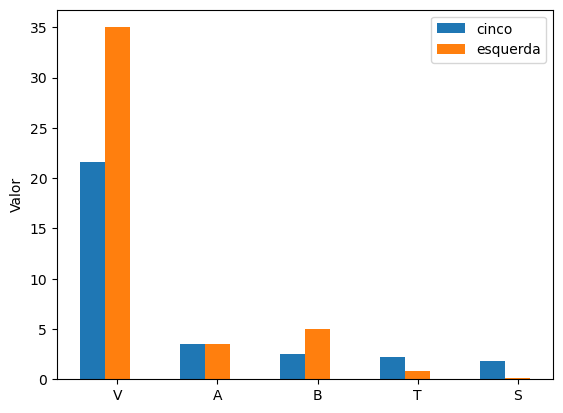

In [202]:
indices = list(range(5))
largura = 0.25
indices_m = [el-largura for el in indices]

f, axs = pylab.subplots(1,1)

axs.bar(indices_m, resultado_cinco['x'], width=largura, label='cinco')
axs.bar(indices, resultado_esquerda['x'], width=largura, label='esquerda')
axs.set_ylabel("Valor")
axs.set_xticks(indices)
axs.set_xticklabels(['V', 'A', 'B', 'T', 'S'])
axs.legend()
pylab.show()

Os resultados são completamento distintos. Podemos ver os erros de validação com as duas soluções sobre o mesmo conjunto.

In [ ]:
print("calibracao cinco, erro de valicao cinco", simula_validacao_cinco(resultado_cinco['x']))
print("calibracao esquerda, erro de valicao cinco", simula_validacao_cinco(resultado_esquerda['x']))
print("calibracao cinco, erro de valicao esquerda", simula_calibracao_faixa_esquerda(resultado_cinco['x']))
print("calibracao esquerda, erro de valicao esquerda", simula_calibracao_faixa_esquerda(resultado_esquerda['x']))


calibracao cinco, erro de valicao cinco 15.894734223758096
calibracao esquerda, erro de valicao cinco 8.233875861415207
calibracao cinco, erro de valicao esquerda 21.62611690539309
calibracao esquerda, erro de valicao esquerda 8.371926662300682


4 108956.79336723739


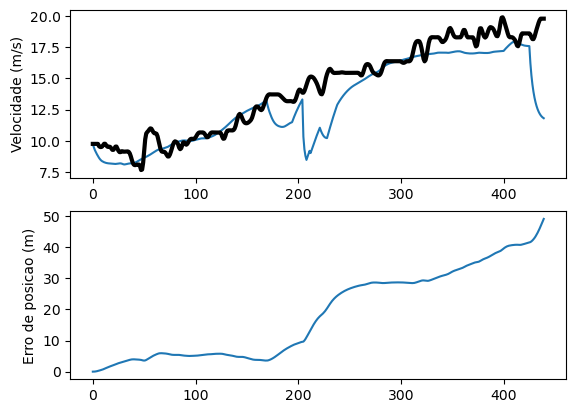

4 81524.99996668028


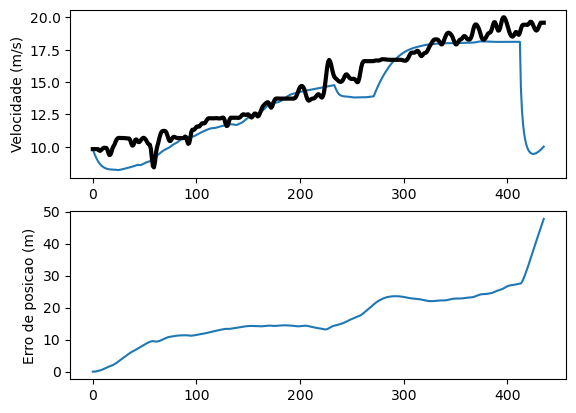

4 129014.07264541226


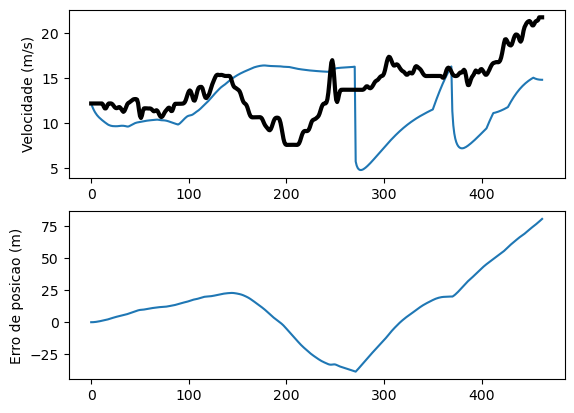

4 4751.60321605977


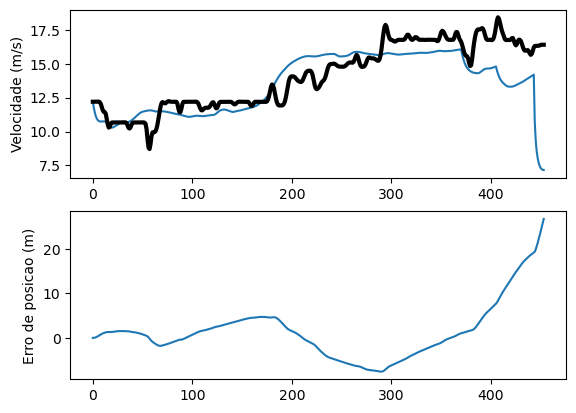

4 135015.37438965257


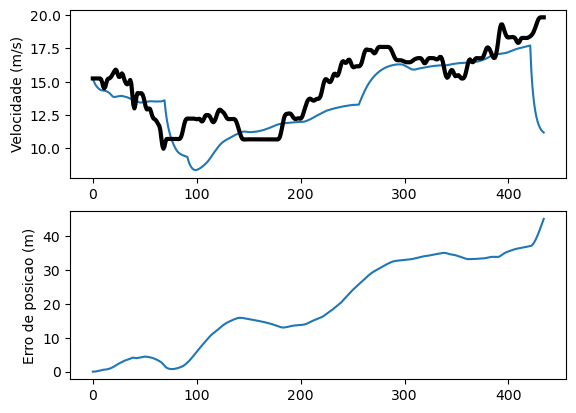

4 28193.133667989507


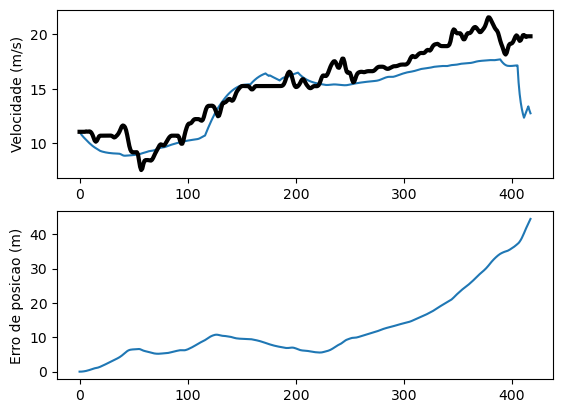

4 122331.37431356955


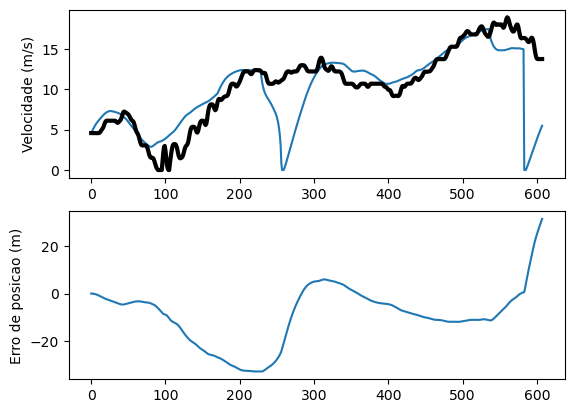

4 64891.28938529087


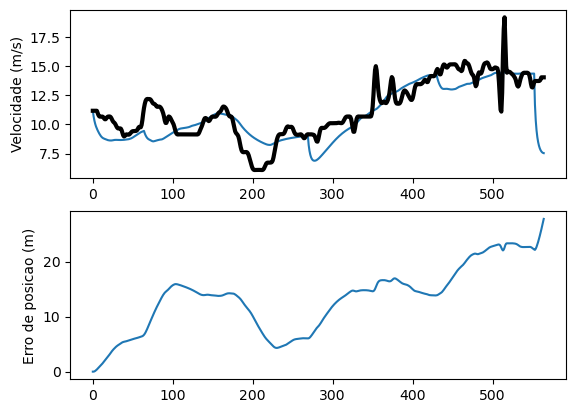

4 39256.680209008526


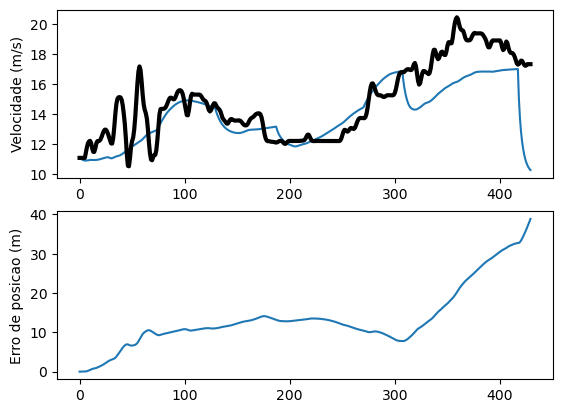

4 230858.6337934114


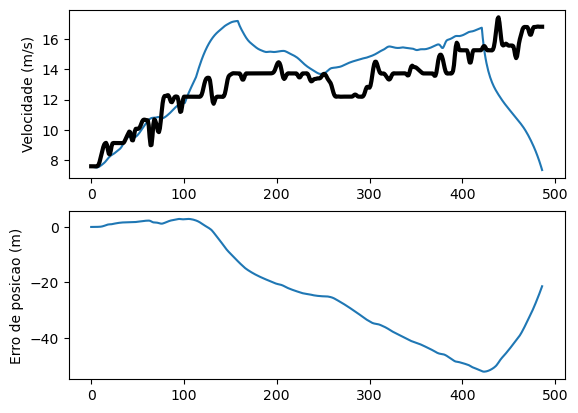

In [ ]:
total_plotar = 10
V, A, B, T, S_0 = resultado_esquerda.x
for id_veiculo in entradas_por_veiculo:
    
    f, axs = pylab.subplots(2)
    v0 = entradas_por_veiculo[id_veiculo]['velocidades_observadas'][0]
    vetor_simulado = processa_idm(v0, entradas_por_veiculo[id_veiculo]['vetor_lider'],
                                  V, A, B, T, S_0, 4, 0.1)
    axs[0].plot(vetor_simulado[:, VEL])
    axs[1].plot(entradas_por_veiculo[id_veiculo]['posicoes_observadas']-vetor_simulado[:,POS], label=u)
    print(u, funcao_objectivo(entradas_por_veiculo[id_veiculo]['posicoes_observadas'], vetor_simulado))
    
    axs[0].plot(entradas_por_veiculo[id_veiculo]['velocidades_observadas'], color='black', linewidth=3)
    axs[0].set_ylabel("Velocidade (m/s)")
    axs[1].set_ylabel("Erro de posicao (m)")

    pylab.show()

    total_plotar -= 1
    if total_plotar <= 0:
        break

Vamos fazer a mesma análise mas com a mesma quantidade de veículos que tem menos trocas de líderes devido a troca de faixas.

In [ ]:
#mesma análise aqui

import random


In [125]:

for lista in [calibracao, validacao]:

    for id_veiculo in lista:
        df_veiculo = df[df['Vehicle_ID']==id_veiculo].reset_index()

        velocidades_observadas = 0.3049*df_veiculo['v_Vel'].to_numpy()
        posicoes_observadas = numpy.zeros(velocidades_observadas.shape)
        for t in range(1, velocidades_observadas.shape[0]):
            posicoes_observadas[t] = posicoes_observadas[t-1]+velocidades_observadas[t-1]*PASSO_NGSIM
        
        vetor_lider = numpy.zeros((velocidades_observadas.shape[0], 2))
        vetor_lider[:,VEL] = df_veiculo['Preceeding_Vel'].to_numpy()*0.3049
        vetor_lider[:, POS] = posicoes_observadas+df_veiculo['Space_Hdwy'].to_numpy()*0.3049

        entradas_por_veiculo[id_veiculo] = {'velocidades_observadas': velocidades_observadas,
                                            'posicoes_observadas': posicoes_observadas,
                                            'vetor_lider': vetor_lider}


In [126]:
def simula_calibracao_todos(parametros):
    return simula_modelo(parametros, calibracao)

def simula_validacao_todos(parametros):
    return simula_modelo(parametros, validacao)

In [129]:
from scipy.optimize import differential_evolution

resultado = differential_evolution(simula_calibracao_todos, [(20.0, 35.0), (1.0, 3.5), (2.5, 5.0),(0.8, 2.2), (0, 10)])
print(resultado)

             message: Optimization terminated successfully.
             success: True
                 fun: 9.34829902600858
                   x: [ 3.500e+01  3.500e+00  5.000e+00  8.000e-01
                        5.027e-01]
                 nit: 25
                nfev: 2010
          population: [[ 3.474e+01  3.499e+00 ...  8.008e-01  5.393e-01]
                       [ 3.366e+01  3.482e+00 ...  8.083e-01  4.701e-01]
                       ...
                       [ 3.454e+01  3.460e+00 ...  8.162e-01  8.783e-01]
                       [ 3.496e+01  3.500e+00 ...  8.071e-01  5.127e-01]]
 population_energies: [ 9.348e+00  9.463e+00 ...  9.451e+00  9.477e+00]
                 jac: [-1.260e-02 -6.988e-01 -4.360e-01  2.107e+00
                        1.776e-06]


In [130]:
print(simula_calibracao_todos(resultado['x']), simula_validacao_todos(resultado['x']))

9.34829902600858 10.347289564713012


4 97452.41922753854


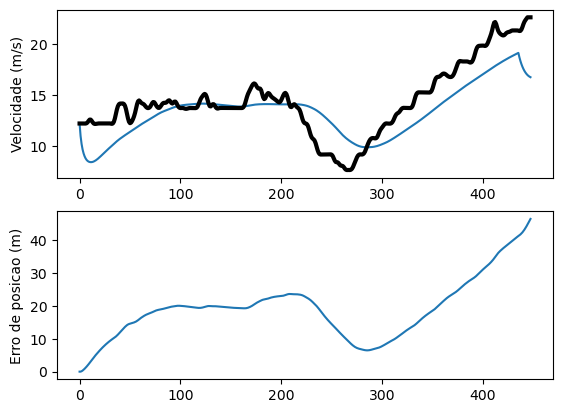

4 76674.06966739762


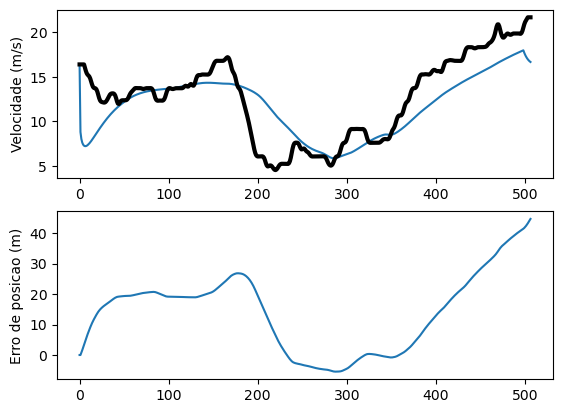

4 28548.874376536914


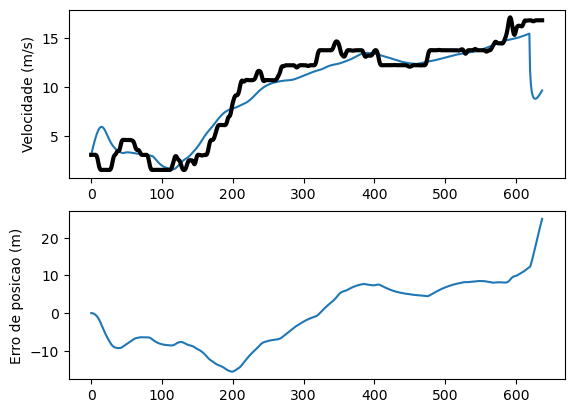

4 72388.21643842752


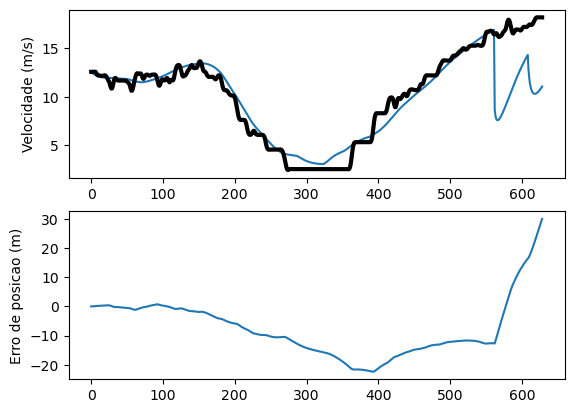

4 21181.673643335875


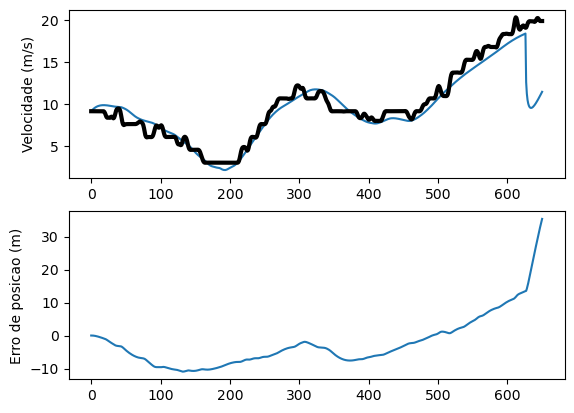

4 135117.07603474738


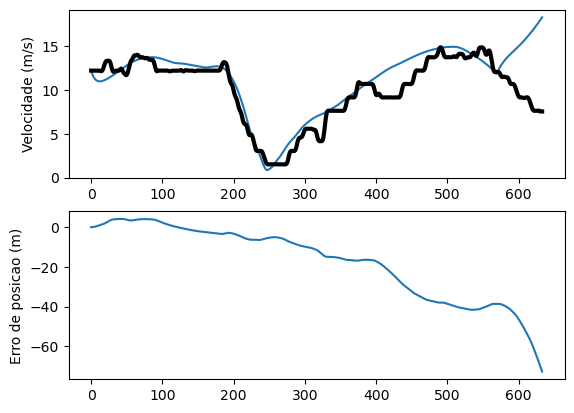

4 7236.809101683481


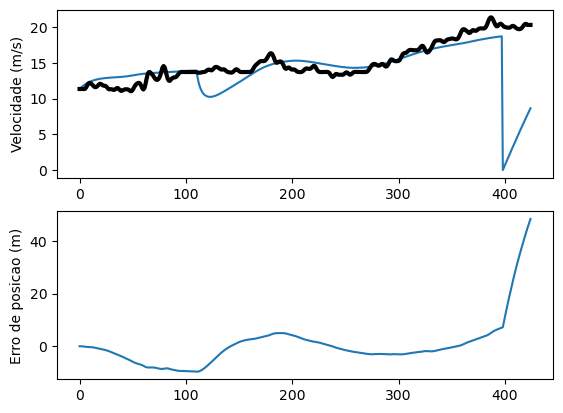

4 27387.698603832243


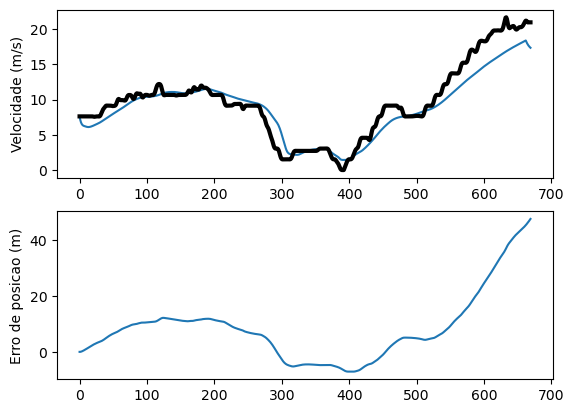

In [131]:
total_plotar = 8
V, A, B, T, S_0 = resultado.x
for id_veiculo in validacao:
    
    f, axs = pylab.subplots(2)
    v0 = entradas_por_veiculo[id_veiculo]['velocidades_observadas'][0]
    vetor_simulado = processa_idm(v0, entradas_por_veiculo[id_veiculo]['vetor_lider'],
                                  V, A, B, T, S_0, 4, 0.1)
    axs[0].plot(vetor_simulado[:, VEL])
    axs[1].plot(entradas_por_veiculo[id_veiculo]['posicoes_observadas']-vetor_simulado[:,POS], label=u)
    print(u, funcao_objectivo(entradas_por_veiculo[id_veiculo]['posicoes_observadas'], vetor_simulado))
    
    axs[0].plot(entradas_por_veiculo[id_veiculo]['velocidades_observadas'], color='black', linewidth=3)
    axs[0].set_ylabel("Velocidade (m/s)")
    axs[1].set_ylabel("Erro de posicao (m)")

    pylab.show()

    total_plotar -= 1
    if total_plotar <= 0:
        break

Dados de trajetória microscópica podem auxiliar estudar muito mais aspectos do que dados macroscópicos em geral. O fato de acharmos resultados distintos para condições diferentes é evidência disso.

Nos anos recentes há um grande aumento de conjunto de dados novos com características diferentes que vamos dar uma pincelada agora.

Há uma série destes focados na tecnologia ACC (Adaptive Cruise Control) e alguns conjunto de dados se tornaram abertos:

- ACC Daniel Work e seus alunos https://vanderbilt.box.com/v/accData : contem vários pares de veículos com um líder prescrevendo uma trajetória estipulada e os veículos seguindo com adaptive cruise control habilitado com ajustes diferentes
- OpenAcc (data.europa.eu): iniciativa de pesquisadores na europa específicos para veículos com adaptive cruise control (veja lista abaixo)

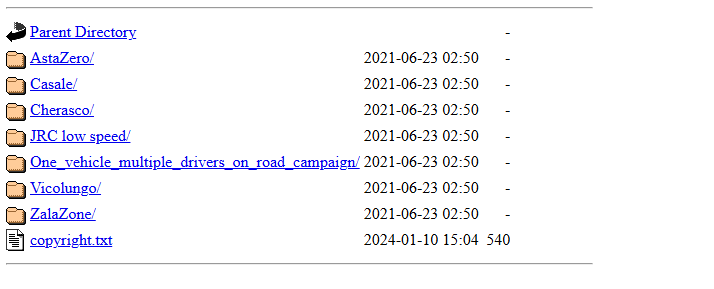

Aqui abaixo um print do part4.csv do conjunto de dados de Casale. Veja que sempre são associados pares de veículos

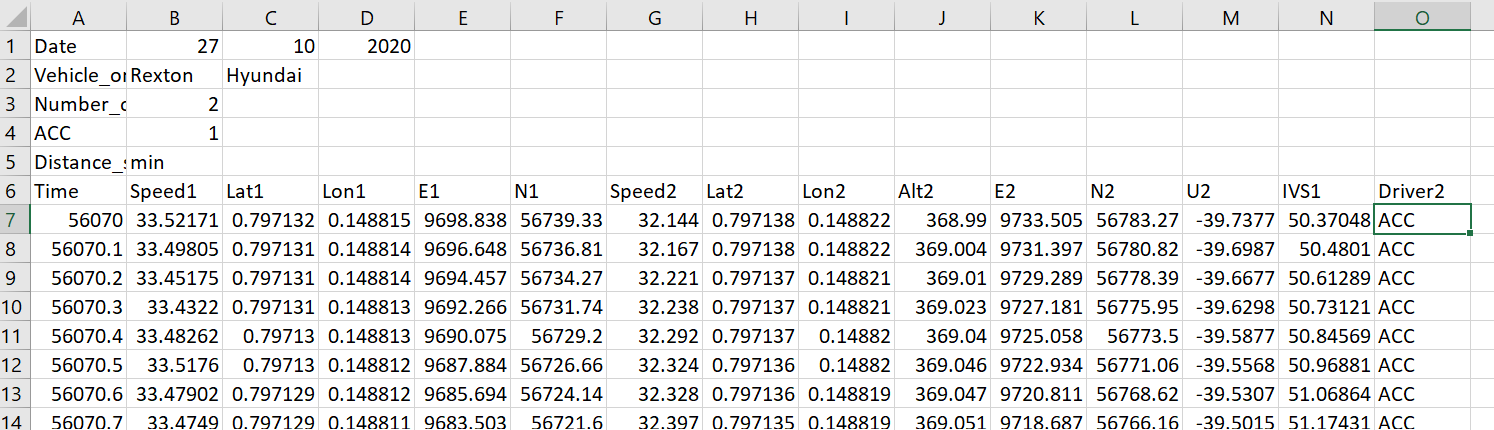

Estes conjunto de dados em geral tem dados mais precisos porque os veículos utilizados no teste são equipados com sensores e GPS.

Gráficos abaixo foi realizado com dados disponibilizados com o grupo do Daniel Work

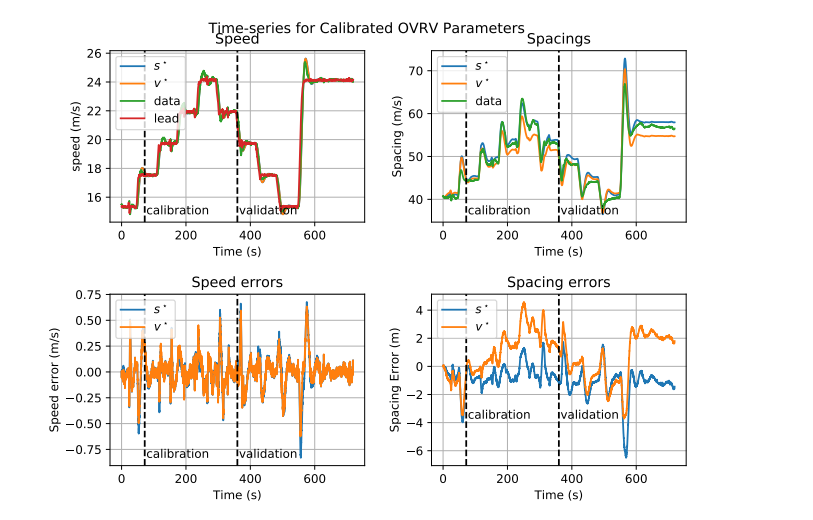

O método de análise básico é parecido como feito até agora. Codicar um ou mais modelos de seguimento veícular, pré-processar os dados e decidir o que é descartado e o que é usado como calibração e validação e calibrar.


Conjunto de dados mais "holísticos" - parecido com o NGSIM no princípio, mas contendo maior número de dias e etc.


- conjunto de dados HighD em uma rodovia na Alemanha - https://levelxdata.com/highd-dataset/ : nunca testei, mas dizem que é mais preciso que o NGSIM e permite analisar acelerações e são 110 mil veículos
- DOT americano possui portal aberto: https://its.dot.gov/data/
- I24 Motion (https://i24motion.org/) - Vanderbilt university e o DOT local estão guardando dados de câmeras ao longo de uma única rodovia
         - parecido com a cobertura de dados de laço indutivos mas com quase todas as trajetórias de todos os veículos
         - porém requer algum pré-processamento e re-identificação mas no geral interessante

Em geral estes conjunto de dados contendo trajetórias também contém dados de laço indutivos.

Em áreas semaforizadas começaram aparecer conjunto de dados com gravações realizadas por drones.

pNEUMA dataset: https://zenodo.org/records/10491409 / https://open-traffic.epfl.ch/


Vejam que todos são por processamento de imagens, portanto:
- veículos podem não ser "seguidos" e reidenticados em quadros sucessivos levando a descontinuidades de posição e velocidade (como o NGSIM...)
- a identificação de faixa pode não ser confiável (como o NGSIM...)
- há sempre uma pequena descontinuidade de velocidade e posição quando veículos saem de uma área de cobertura de uma câmera e entra em outra.


Portanto, pré-processamento é chave!
